To identify strong predictors of recombinant protein expression experiments, we first examined Cambray *et al.* dataset (2018) that consists of the abundance of green fluorescence protein (GFP) from *Escherichia coli* transformed using 244,000 plasmid constructs. This dataset has a total of 244,000 different combinations of 33 N-terminal codons fused in-frame with superfold GFP sequence, which is suitable for studying the features around translation initiation sites.

Supplementary Data 15 by Cambray *et al.* is very large to download (125 MB). ```cambray.cdhit.fa``` and ```cambray.cdhit.txt``` in this repo can be used instead.

```console
mkdir -p data
cd data
wget https://media.nature.com/original/nature-assets/nbt/journal/v36/n10/extref/nbt.4238-S47.zip
md5sum nbt.4238-S47.csv.zip
```

```console
177afbcae1732c7c4bd5f444f6c99d10  nbt.4238-S47.csv.zip
```

This csv file contains four columns of our interest- ```id```, ```gs.utrCdsStructureMFE```, ```clean.lin.prot.mean```, and ```gs.sequence```, which correspond to sequence ID, folding energy from position -30 to 30 nt (centered at start codon), GFP level, and 33 N-terminal codons, respectively. Representative sequences of 33 N-terminal codons were selected using ```cd-hit-est```.

```console
unzip nbt.4238-S47.zip
awk 'BEGIN{FS=","} NR>1 {gsub("\"", ""); print ">" $1, $15, $33 "\n" toupper($5)}' \
Supplementary_Data_15_Integrated_Phenotypic_Measurements.csv > cambray.fa
cd-hit-est -i cambray.fa -o cambray.cdhit.fa -c 0.8 -p 1
awk 'BEGIN{OFS="\t"} />/ {sub(">",""); gsub(" ","\t"); print $1,$2,$3}' cambray.cdhit.fa \
| sed '1i id\tFolding energy (kcal/mol)\tProtein abundance' > cambray.cdhit.txt
```

Accessibility of the GFP sequences was calculated using an ```RNAplfold``` wrapper script ```openen.py```.

```console
# Addgene 113408
UTR5=AAAAAGAGTATTGACTTATTGTGAGCGGATAACATATAATGTGTGGAGGGCCCAAGTTCACTTAAAAAGGAGATCAACAATGAAAGCAATTTAGGTACTGAAACATCTTAATCATGCACATAAGGAGGTACCATA
GFP=GGTGGATCCGGTGGATCGGGCGGGTCATACTACCATCACCACCACCACCATTTGGAGTCGGAAAATTTATACTTCCAATCCGGTTCCGCCGGATCTGCTGCCGGTTCCGGTGAATTTAGCAAAGGAGAAGAACTTTTCACCGGAGTAGTCCCGATTCTGGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCCGTGGAGAGGGTGAAGGTGATGCTACAAACGGAAAACTCACCCTTAAATTCATTTGCACAACGGGAAAACTACCAGTACCGTGGCCAACACTGGTCACTACTCTGACCTATGGTGTTCAATGCTTTTCCCGTTATCCGGATCACATGAAACGGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAACGCACTATATCTTTCAAAGATGACGGGACCTACAAGACGCGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATCGTATCGAGTTAAAGGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAACTCGAGTACAACTTTAACTCACACAATGTATACATCACGGCAGACAAACAAAAGAATGGAATCAAAGCTAACTTCAAAATTCGCCACAACGTTGAAGATGGTTCCGTTCAACTAGCTGAGCATTATCAACAAAATACTCCAATTGGAGATGGACCTGTCCTTTTACCAGACAACCATTACCTGTCGACACAATCTGTCCTTTCGAAAGATCCCAACGAAAAGCGTGACCACATGGTCCTTCTTGAGTTTGTAACTGCTGCTGGGATTACACATGGCATGGATGAGCTCTACAAATAAGGATCGGTTGTCGAGTAAGGATCTCCAGGCATCAAATAAAACGAAAGGCTCAGTCGAAAGACTGGGCCTTTCGTTTTATCTGTTGTTTGTCGGTGAACGCTCTCTACTAGAGTCACACTGGCTCACCTTCGGGTGGGCCTTTCTGCGTTTATA

# Concatenate 5'UTR, 33 N-terminal codons and GFP sequences 
awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print RS$0}' cambray.cdhit.fa \
| awk -v i=$UTR5 -v j=$GFP '{print $1 "\n" i "ATG" $NF j}' > cambray.cdhit.gfp.fa

# 5'UTR length is 135
python ../openen.py -s cambray.cdhit.gfp.fa -U 1 -x -e -n 135 -S
cd ..
```

```.pkl``` and ```.out``` output files were used for correlation analysis as follows.

In [1]:
import os
import csv
from datetime import datetime
from functools import reduce
import numpy as np
from numpy import nan as Nan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.metrics import roc_curve, auc

# Calculate correlation of protein abundance and opening energy
# at individual transcript subsegments
def correlation(j, d):
    for i in list(range(0,j)):
        yield d[pd.np.r_[i, j]].corr(method='spearman')[i][j]

# Calculate AUC of recombinant protein expression results and opening energy
# at individual transcript subsegments
def roc(outcomes, d):
    for predictions in list(range(0,outcomes)):
        df = d[pd.np.r_[predictions, outcomes]]
        fpr, tpr, _ = roc_curve(df[outcomes], -df[predictions])
        a = auc(fpr, tpr)
        yield predictions, a

# Flatten _openen files
# n is 5UTR length
# t is downstream distance to start codon to include
def openen_label(n, t, f):
    d = pd.read_csv(f, sep='\t', skiprows=2, nrows=(n+t), header=None)
    d = d.set_index(0).stack().to_frame()
    d = d.index.to_frame()
    d.columns = ["Position 'i' centered at the start codon", "Subsegment 'l'"]
    d = d.reset_index()[["Position 'i' centered at the start codon", "Subsegment 'l'"]]
    d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"] - n
    return d

# Get opening energy at a specific subsegment 'l'
# and position 'i' centered at the start codon
def get_openen(n, t, f1, l, i, f2):
    label = openen_label(n, t, f1)
    d = pd.read_pickle(f2)
    d = d.set_index('id')
    d = d.T
    d = pd.concat([label, d], axis=1)
    o = d.loc[(d["Subsegment 'l'"] == l) & (d["Position 'i' centered at the start codon"] == i)]
    o = o.T[2:]
    o.columns = ['Opening energy']
    return o

# Fig 1 and 2
def plot_joinplot(x, y, d, c, savepdf=None):
    %matplotlib inline
    if savepdf:
        %config InlineBackend.figure_format = 'pdf'
        sns.set(font_scale=1.6)
        sns.set_style('ticks')
        sns.jointplot(x, y, data=d, color=c, kind='kde', space=0)
        fname = 'joinpoint_' + str(datetime.now()).replace(" ","_") + '.pdf'
        fpath = os.path.join(os.getcwd(), 'data', fname)
        plt.savefig(fpath)
    else:
        %config InlineBackend.figure_format = 'retina'
        sns.set(font_scale=1.6)
        sns.set_style('ticks')
        sns.jointplot(x, y, data=d, color=c, kind='kde', space=0)
        
# Fig 2 and Supplementary Fig S1
# span is the tick interval of x- or y- axis
def plot_heatmap(xspan, yspan, d, colorflip=None, savepdf=None):
    %matplotlib inline
    if colorflip:
        cmap = sns.cm.rocket_r
    else:
        cmap = sns.cm.rocket
    if savepdf:   
        %config InlineBackend.figure_format = 'pdf'
        plt.rcParams['figure.figsize'] = [9, 4.5]     
        sns.set(font_scale=1.5)
        sns.set_style('ticks')
        sns.heatmap(d, cmap = cmap, xticklabels=xspan, yticklabels=yspan)
        fname = 'heatmap_' + str(datetime.now()).replace(" ","_") + '.pdf'
        fpath = os.path.join(os.getcwd(), 'data', fname)
        plt.savefig(fpath)
    else:
        %config InlineBackend.figure_format = 'retina'
        plt.rcParams['figure.figsize'] = [9, 4.5]
        sns.set(font_scale=1.5)
        sns.set_style('ticks')
        sns.heatmap(d, cmap = cmap, xticklabels=xspan, yticklabels=yspan)

In [2]:
# Read in pickle file for correlation analysis
d = pd.read_pickle('data/openen.cambray.pkl')
d.head()

,id,0,1,2,3,4,5,6,7,8,...,27395,27396,27397,27398,27399,27400,27401,27402,27403,27404
0,1_11111113_1,0.0027,0.0061,0.0077,0.0529,0.0573,0.0589,0.0720,0.0927,0.0964,...,57.3627,57.2981,57.2577,57.1814,57.1046,57.0203,56.9116,56.7795,56.5800,56.8805
1,1_11111112_1,0.0024,0.0050,0.0064,0.0511,0.0517,0.0520,0.0553,0.0738,0.0728,...,53.5835,53.5194,53.4718,53.4098,53.3380,53.2667,53.1730,53.0874,52.9976,52.8122
2,1_11112111_1,0.0006,0.0013,0.0017,0.0055,0.0065,0.0074,0.0089,0.0112,0.0119,...,53.5211,53.4575,53.4080,53.3446,53.2620,53.1955,53.1184,53.0624,53.0247,52.9689
3,1_11112113_1,0.0008,0.0024,0.0031,0.0058,0.0081,0.0089,0.0130,0.0158,0.0181,...,48.7943,48.7300,48.6836,48.6203,48.5583,48.4840,48.3841,48.2854,48.1654,47.9369
4,1_11111121_1,0.0036,0.0072,0.0093,0.0695,0.0735,0.0753,0.0753,0.1019,0.1049,...,50.4474,50.3861,50.3336,50.2746,50.1925,50.1399,50.0953,50.1010,50.2264,50.4838


In [3]:
f = pd.read_csv('data/cambray.cdhit.txt', sep='\t')
f.head()

,id,Folding energy (kcal/mol),Protein abundance
0,1_11111111_1,-12.6,27.510097
1,1_11111112_1,-11.6,36.376262
2,1_11111113_1,-14.1,16.825186
3,1_11111121_1,-13.2,11.591014
4,1_11111123_1,-14.8,6.801931


In [ ]:
# Assign the column name 'Protein abundance' to 27405, i.e., the last column number
# and join the dataframes for calculating correlation
f = f[['id','Protein abundance']]
f.columns = ['id', 27405]
d = pd.merge(d, f, on='id')

In [ ]:
# Calculate correlation at individual subsegment 'l' (length 1 to 'u')
corr = pd.DataFrame(correlation(27405, d))
corr.columns = ['corr']
# Get labels (row and column names) from an _openen file
# Join labels and correlation values
label = openen_label(135, 100, 'data/321_23311221_1_openen')
d = pd.concat([label, corr], axis=1)
d.to_pickle('data/corr.cambray.pkl')

In [4]:
# Opening energy at i=18 and l=48 (transcript position -29 to 18 nt)
# has the strongest correlation with protein level
d = pd.read_pickle('data/corr.cambray.pkl')
d.sort_values('corr').head()

,Position 'i' centered at the start codon,Subsegment 'l',corr
11675,18,48,-0.646008
11674,18,47,-0.645767
11676,18,49,-0.645478
11677,18,50,-0.644265
11678,18,51,-0.643979


In [5]:
# Add padding to x-axis
d_dummy = pd.DataFrame([-135,1,Nan], index=["Position 'i' centered at the start codon", "Subsegment 'l'", 'corr']).T
d = d_dummy.append(d)
d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"].astype('int')
d["Subsegment 'l'"] = d["Subsegment 'l'"].astype('int')

In [6]:
# Transform correlation values to a dataframe similar to that of _openen
d = d.pivot(index="Position 'i' centered at the start codon", columns="Subsegment 'l'", values='corr').T.sort_values("Subsegment 'l'", ascending=False)

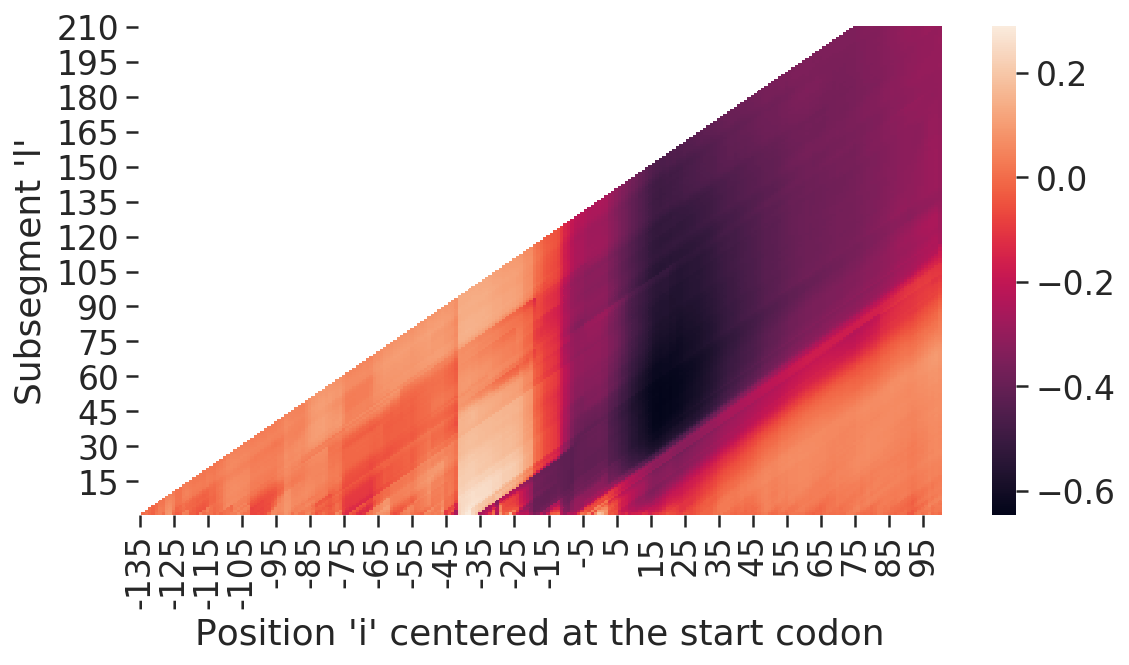

In [7]:
# Fig 2A and Supplementary Fig 1A, left panel
plot_heatmap(10, 15, d)

In [8]:
# Get opening energy at transcript position -29 to 18 nt
o = get_openen(135, 100, 'data/321_23311221_1_openen', 48, 18, 'data/openen.cambray.pkl')

In [9]:
# Calculate pairwise correlation
f = pd.read_csv('data/cambray.cdhit.txt', sep='\t')
f = f.set_index('id')
d = pd.concat([o, f], sort=True, axis=1)
d.corr(method='spearman')

,Opening energy,Folding energy (kcal/mol),Protein abundance
Opening energy,1.000000,-0.577458,-0.646008
Folding energy (kcal/mol),-0.577458,1.000000,0.509407
Protein abundance,-0.646008,0.509407,1.000000


In [10]:
# d[d.isnull().any(1)]
spearmanr(d['Folding energy (kcal/mol)'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=0.5094070220472339, pvalue=0.0)

In [11]:
spearmanr(d['Opening energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=-0.6460079512251886, pvalue=0.0)

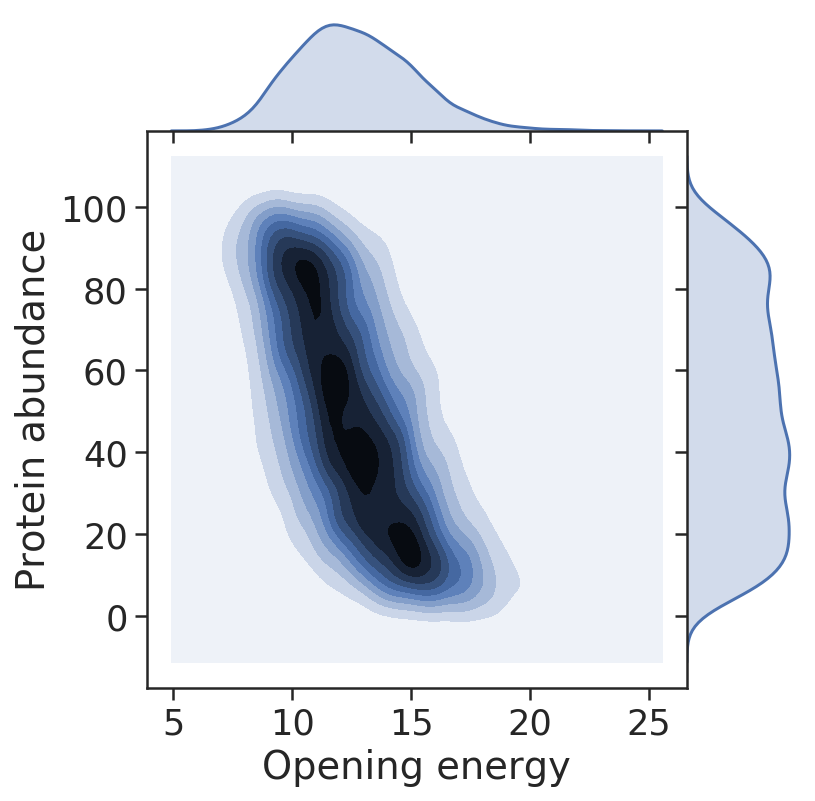

In [12]:
# Fig 1A
plot_joinplot('Opening energy', 'Protein abundance', d, 'b')

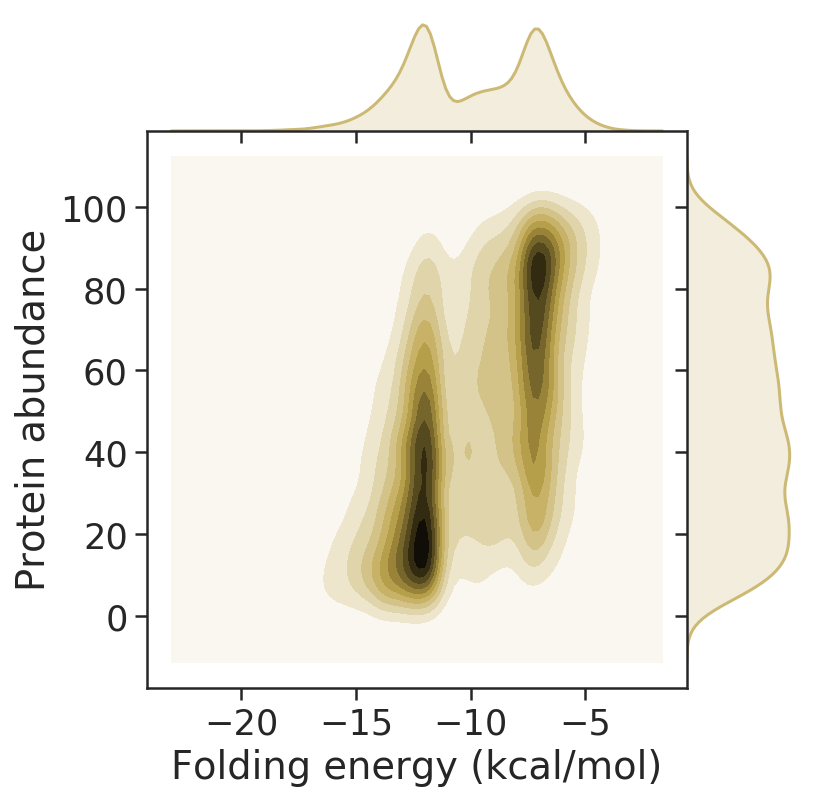

In [13]:
plot_joinplot('Folding energy (kcal/mol)', 'Protein abundance', d, 'y')

For *Saccharomyces cerevisiae*, we analyzed Dvir et al. dataset (2013) that consists of the abundance of yellow fluorescence protein (YFP) from *S. cerevisiae* transformed using 2,041 plasmid constructs. This dataset has a total of 2,041 random decameric nucleotides inserted at the upstream of YFP start codon. Steps are similar as above.

```console
# Table S4 and Method S2, https://www.pnas.org/highwire/filestream/613140/field_highwire_adjunct_files/0/sapp.pdf
UTR5=ACATAAATAATTTCTATTAACAATGTAATTTCCATAATTTTATATTCCTCTCCACCTTCTATTGCATCATGTACTATTCAAATGACTGTAACACTAGTATTATGAAGAAAACACCCAAACATATCTAGGCCATCAGATTTTTTTTTTTTCATTTTTCATTTTTTTCTCATTTTCTTATTTATTTTTATTGAAAAATAATAACCGACGCAAACAAATTGGAAAAACCAACGCAAAAAAAAAGACGCTAAATTGTTTATAAAGGCGAGGAATTTGTATCTATCAATTACTATTCCAGTTGTCAGTTTACATTGCTTACCCTCTATTATCACATCAAAACAA
YFP=ATGTCTAAAGGTGAAGAATTATTCACTGGTGTTGTCCCAATTTTGGTTGAATTAGATGGTGATGTTAATGGTCACAAATTTTCTGTCTCCGGTGAAGGTGAAGGTGATGCTACTTACGGTAAATTGACCTTAAAATTGATTTGTACTACTGGTAAATTGCCAGTTCCATGGCCAACCTTAGTCACTACTTTAGGTTATGGTTTGCAATGTTTTGCTAGATACCCAGATCATATGAAACAACATGACTTTTTCAAGTCTGCCATGCCAGAAGGTTATGTTCAAGAAAGAACTATTTTTTTCAAAGATGACGGTAACTACAAGACCAGAGCTGAAGTCAAGTTTGAAGGTGATACCTTAGTTAATAGAATCGAATTAAAAGGTATTGATTTTAAAGAAGATGGTAACATTTTAGGTCACAAATTGGAATACAACTATAACTCTCACAATGTTTACATCACTGCTGACAAACAAAAGAATGGTATCAAAGCTAACTTCAAAATTAGACACAACATTGAAGATGGTGGTGTTCAATTAGCTGACCATTATCAACAAAATACTCCAATTGGTGATGGTCCAGTCTTGTTACCAGACAACCATTACTTATCCTATCAATCTGCCTTATCCAAAGATCCAAACGAAAAGAGAGACCACATGGTCTTGTTAGAATTTGTTACTGCTGCTGGTATTACCCATGGTATTGATGAATTGTACAAATAA

# Download supplementary data and calculate opening energy
wget https://www.pnas.org/highwire/filestream/613140/field_highwire_adjunct_files/1/sd01.xlsx
libreoffice --headless --convert-to csv sd01.xlsx
awk -v u=$UTR5 -v s=$YFP 'BEGIN{FS=","} NR>1 {print ">" $1 "\n" u $1 s}' sd01.csv > dvir13.fa
python ../openen.py -s dvir13.fa -U 1 -i 350 -S -k 300 -p 32 -o openen.dvir

# Get folding energy from position -30 to 30 nt (centered at start codon)
awk 'BEGIN{FS=","} NR>1 {print ">" $1 "\nCTATTATCACATCAAAACAA" $1 "ATGTCTAAAGGTGAAGAATTATTCACTGGT"}' sd01.csv \
| RNAfold --noPS \
| awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print $0}' \
| awk '{gsub(/\(|\)/," "); print $1 "\t" $NF}' \
| sed '1i id\tFolding energy (kcal/mol)' > rnafold.dvir.out
cd ..
```

In [14]:
d = pd.read_pickle('data/openen.dvir.pkl')
d.head()

,id,0,1,2,3,4,5,6,7,8,...,114545,114546,114547,114548,114549,114550,114551,114552,114553,114554
0,CACGCCAATT,0.0948,0.0649,0.1151,0.1197,0.1478,0.1978,0.1065,0.1433,0.1713,...,50.9312,50.9649,51.0038,51.0491,51.1091,51.1932,51.3165,51.3777,51.4689,51.479
0,CCGACCCGTT,0.0948,0.0649,0.1151,0.1197,0.1478,0.1978,0.1065,0.1433,0.1713,...,50.9312,50.9649,51.0038,51.0491,51.1091,51.1932,51.3165,51.3777,51.4689,51.479
0,ACCCGCACGT,0.0948,0.0649,0.1151,0.1197,0.1478,0.1978,0.1065,0.1433,0.1713,...,50.9312,50.9649,51.0038,51.0491,51.1091,51.1932,51.3165,51.3777,51.4689,51.479
0,AGGAACAATT,0.0948,0.0649,0.1151,0.1197,0.1478,0.1978,0.1065,0.1433,0.1713,...,50.9312,50.9649,51.0038,51.0491,51.1091,51.1932,51.3165,51.3777,51.4689,51.479
0,CGACCATATT,0.0948,0.0649,0.1151,0.1197,0.1478,0.1978,0.1065,0.1433,0.1713,...,50.9312,50.9649,51.0038,51.0491,51.1091,51.1932,51.3165,51.3777,51.4689,51.479


In [ ]:
f = pd.read_csv('data/sd01.csv')
f = f[['sequence_variant','mean_protein_abundance']]
f.columns = ['id', 114555]
d = pd.merge(d, f, on='id')

In [ ]:
corr = pd.DataFrame(correlation(114555, d))
corr.columns = ['corr']
label = openen_label(350, 300, 'data/AAAAAAAATC_openen')
d = pd.concat([label, corr], axis=1)
d.to_pickle('data/corr.dvir.pkl')

In [15]:
d = pd.read_pickle('data/corr.dvir.pkl')
d.sort_values('corr').head()

,Position 'i' centered at the start codon,Subsegment 'l',corr
63590,58,66,-0.562323
63591,58,67,-0.561562
63802,59,68,-0.558867
73088,103,114,-0.558500
63803,59,69,-0.558360


In [16]:
# Position i=-220 is a padding at x-axis
d = d[(d["Position 'i' centered at the start codon"]>=-220) & (d["Position 'i' centered at the start codon"]<=210)]
d = d.pivot(index="Position 'i' centered at the start codon", columns="Subsegment 'l'", values='corr').T.sort_values("Subsegment 'l'", ascending=False)

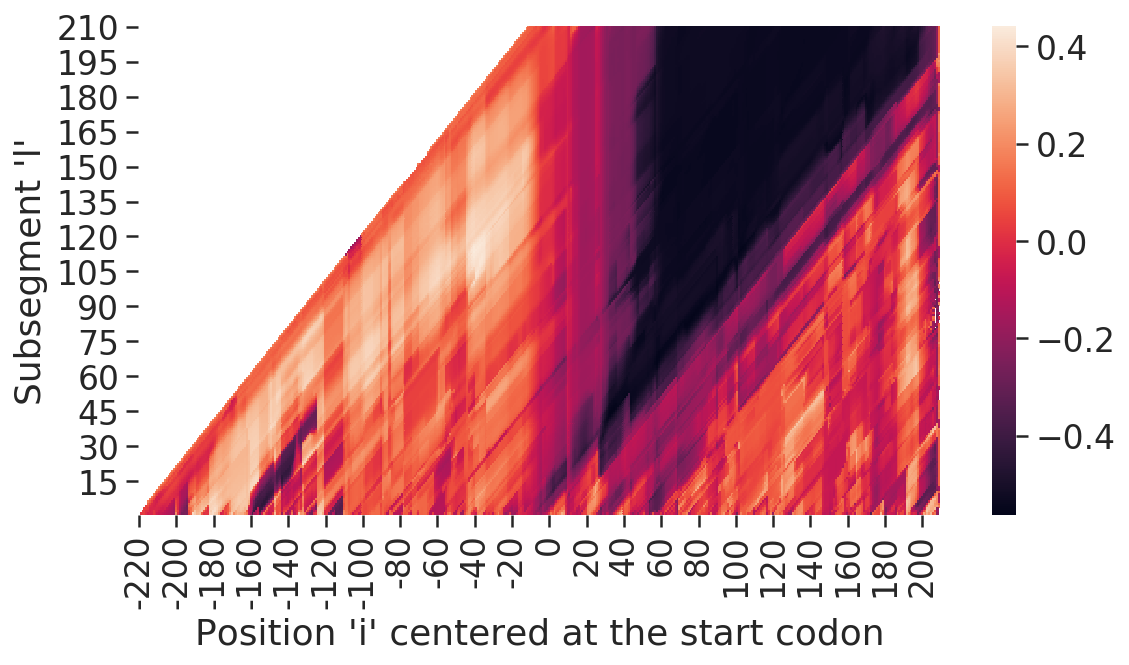

In [17]:
# Supplementary Fig 1B, left panel
plot_heatmap(20, 15, d)

In [18]:
o = get_openen(350, 300, 'data/AAAAAAAATC_openen', 66, 58, 'data/openen.dvir.pkl')
p = pd.read_csv('data/sd01.csv')
p = p[['sequence_variant','mean_protein_abundance']]
p.columns = ['id', 'Protein abundance']
p = p.set_index('id')
f = pd.read_csv('data/rnafold.dvir.out', sep='\t')
f = f.set_index('id')
d = pd.concat([o, f, p], sort=True, axis=1)
d.corr(method='spearman')

,Opening energy,Folding energy (kcal/mol),Protein abundance
Opening energy,1.000000,-0.429458,-0.562323
Folding energy (kcal/mol),-0.429458,1.000000,0.263917
Protein abundance,-0.562323,0.263917,1.000000


In [19]:
spearmanr(d['Opening energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=-0.5623225852702064, pvalue=1.594468042038981e-170)

In [20]:
spearmanr(d['Folding energy (kcal/mol)'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=0.2639167032452177, pvalue=7.193096030508314e-34)

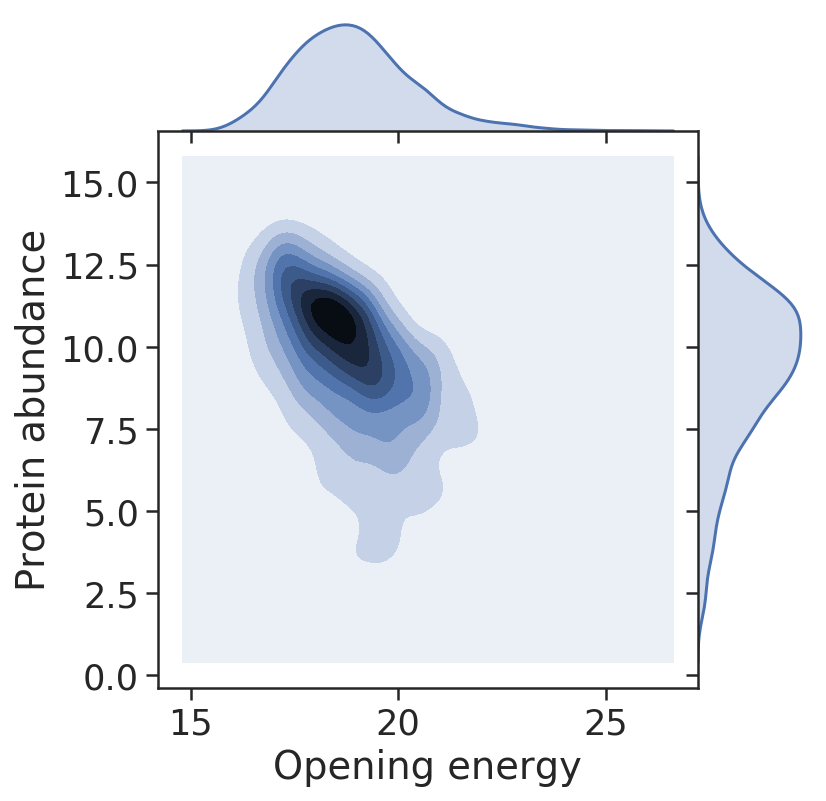

In [21]:
# Fig 1B
plot_joinplot('Opening energy', 'Protein abundance', d, 'b')

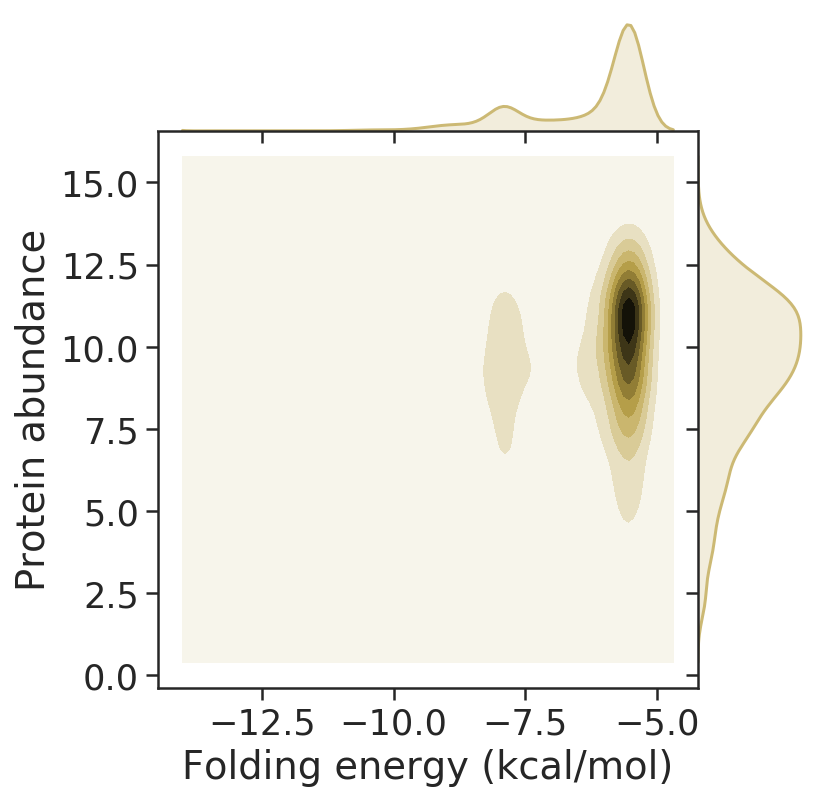

In [22]:
plot_joinplot('Folding energy (kcal/mol)', 'Protein abundance', d, 'y')

For *Mus musculus*, we analyzed Noderer et al. dataset (2014) that consists of the abundance of GFP from stably transduced PD-31 mouse pre-B lymphocytes (65,536 plasmid constructs). This dataset has a total of 65,536 random hexamers and dimers inserted at the upstream and downstream of GFP start codon, respectively. Steps similar are as above.

```console```
# Addgene 49225
UTR5=GTGGACCATCCTCTAGACTGCCGGATCTCGAGTAACTGACTAGT
GFP=CGAATTCAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAA

# Download supplementary data and calculate opening energy
wget http://msb.embopress.org/content/msb/10/8/748/DC6/embed/inline-supplementary-material-6.txt
awk 'NR>2 {gsub("U","T"); print $1 "\t" $2}' inline-supplementary-material-6.txt | sed '1i id\tProtein abundance' > protein.noderer.out
awk -v i=$UTR5 -v j=$GFP 'NR>1 {print ">" $1 "\n" i $1 j}' protein.noderer.out > noderer14.fa
python ../openen.py -s noderer14.fa -U 1 -x -S -n 50 -t 300 -p 16 -o openen.noderer

# Get folding energy from position -30 to 30 nt (centered at start codon)
awk 'NR>1 {print ">" $1 "\nCCGGATCTCGAGTAACTGACTAGT" $1 "CGAATTCAGCAAGGGCGAGGAGCTG"}' protein.noderer.out \
| RNAfold --noPS \
| awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print $0}' \
| awk '{gsub(/\(|\)/," "); print $1 "\t" $NF}' \
| sed '1i id\tFolding energy (kcal/mol)' > rnafold.noderer.out
cd ..
```

In [ ]:
d = pd.read_pickle('data/openen.dvir.pkl')
f = pd.read_csv('data/protein.noderer.out')
f.columns = ['id', 51555]
d = pd.merge(d, f, on='id')

In [ ]:
corr = pd.DataFrame(correlation(51555, d))
corr.columns = ['corr']
label = openen_label(50, 300, 'data/TTCATCATGCA_openen')
d = pd.concat([label, corr], axis=1)
d.to_pickle('data/corr.noderer.pkl')

In [23]:
d = pd.read_pickle('data/corr.noderer.pkl')
d.sort_values('corr').head()

,Position 'i' centered at the start codon,Subsegment 'l',corr
28456,191,2,-0.309288
28245,190,1,-0.309111
29945,198,21,-0.300660
30156,199,22,-0.299920
31323,204,139,-0.298178


In [24]:
# Add padding to x-axis
d_dummy = pd.DataFrame([-50,1,Nan], index=["Position 'i' centered at the start codon", "Subsegment 'l'", 'corr']).T
d = d_dummy.append(d)
d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"].astype('int')
d["Subsegment 'l'"] = d["Subsegment 'l'"].astype('int')
d = d[(d["Position 'i' centered at the start codon"]>=-50) & (d["Position 'i' centered at the start codon"]<=180)]
d = d.pivot(index="Position 'i' centered at the start codon", columns="Subsegment 'l'", values='corr').T.sort_values("Subsegment 'l'", ascending=False)

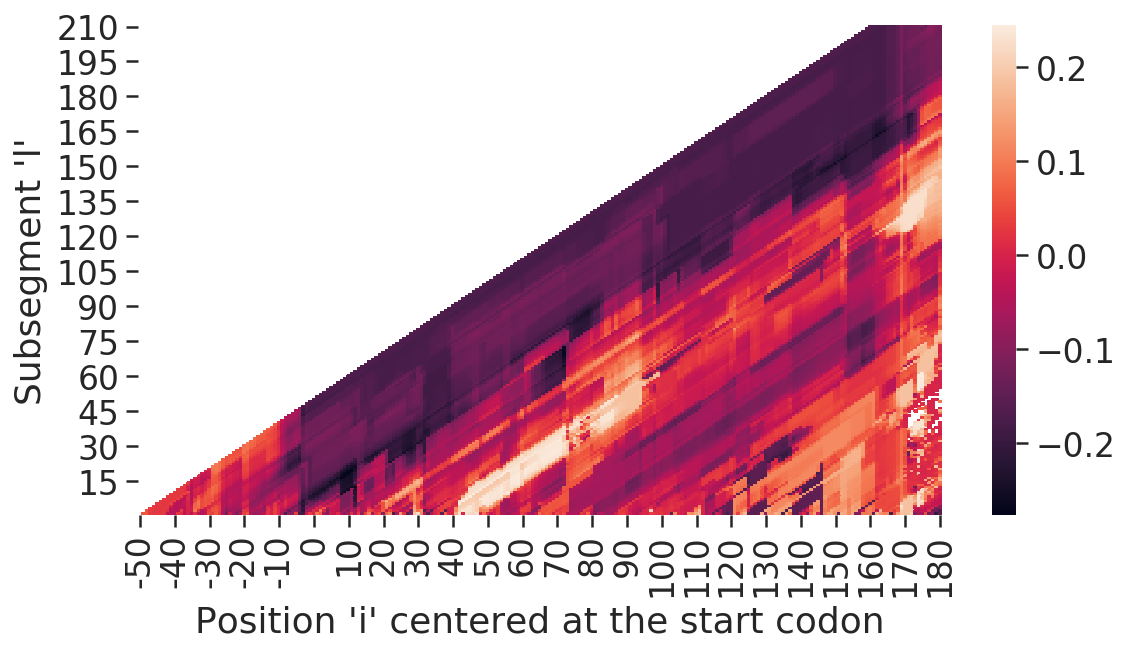

In [25]:
# Supplementary Fig 1C, left panel
plot_heatmap(10, 15, d)

In [26]:
# Supplementary Fig 1C
cambray = pd.read_pickle('data/corr.cambray.pkl')
cambray.rename(columns={'corr':'cambray'}, inplace=True)
dvir = pd.read_pickle('data/corr.dvir.pkl')
dvir.rename(columns={'corr':'dvir'}, inplace=True)
noderer = pd.read_pickle('data/corr.noderer.pkl')
noderer.rename(columns={'corr':'noderer'}, inplace=True)
d = reduce(lambda left,right: pd.merge(left,right,on=["Position 'i' centered at the start codon", "Subsegment 'l'"]), [cambray, dvir, noderer])

In [27]:
d_dummy = pd.DataFrame([-50,1,Nan,Nan,Nan], index=["Position 'i' centered at the start codon", "Subsegment 'l'", 'cambray', 'dvir', 'noderer']).T
d = d_dummy.append(d)
d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"].astype('int')
d["Subsegment 'l'"] = d["Subsegment 'l'"].astype('int')

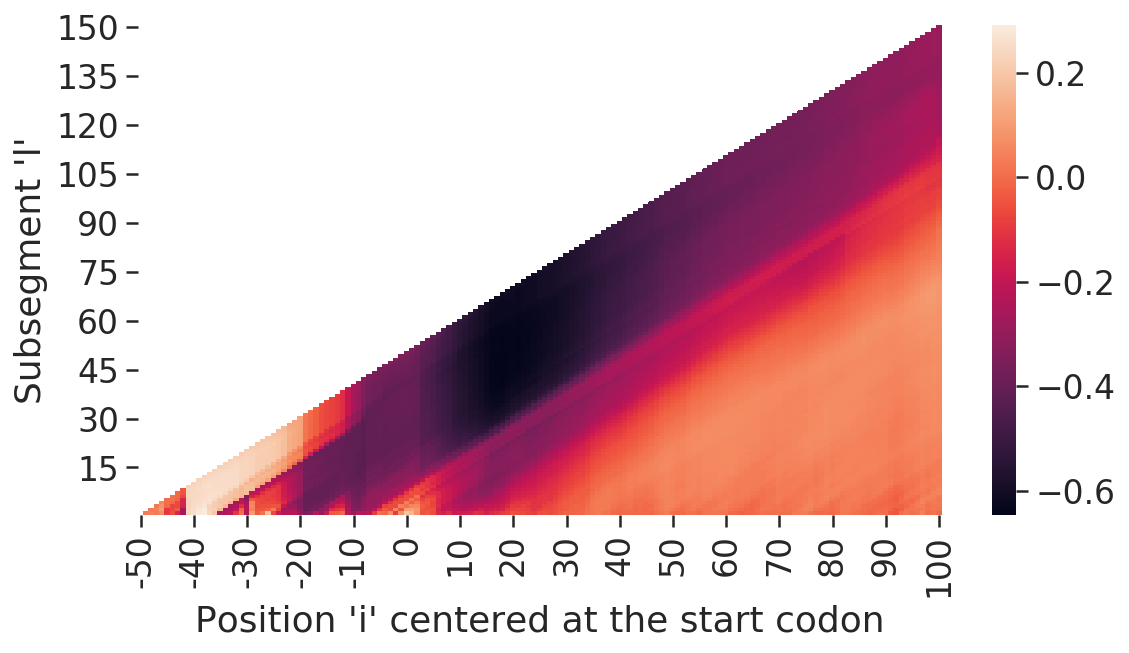

In [28]:
# Supplementary Fig 1A, right panel
cambray = d[["Position 'i' centered at the start codon", "Subsegment 'l'", 'cambray']]
cambray = cambray.pivot(index="Position 'i' centered at the start codon", columns="Subsegment 'l'", values='cambray').T.sort_values("Subsegment 'l'", ascending=False)
plot_heatmap(10, 15, cambray)

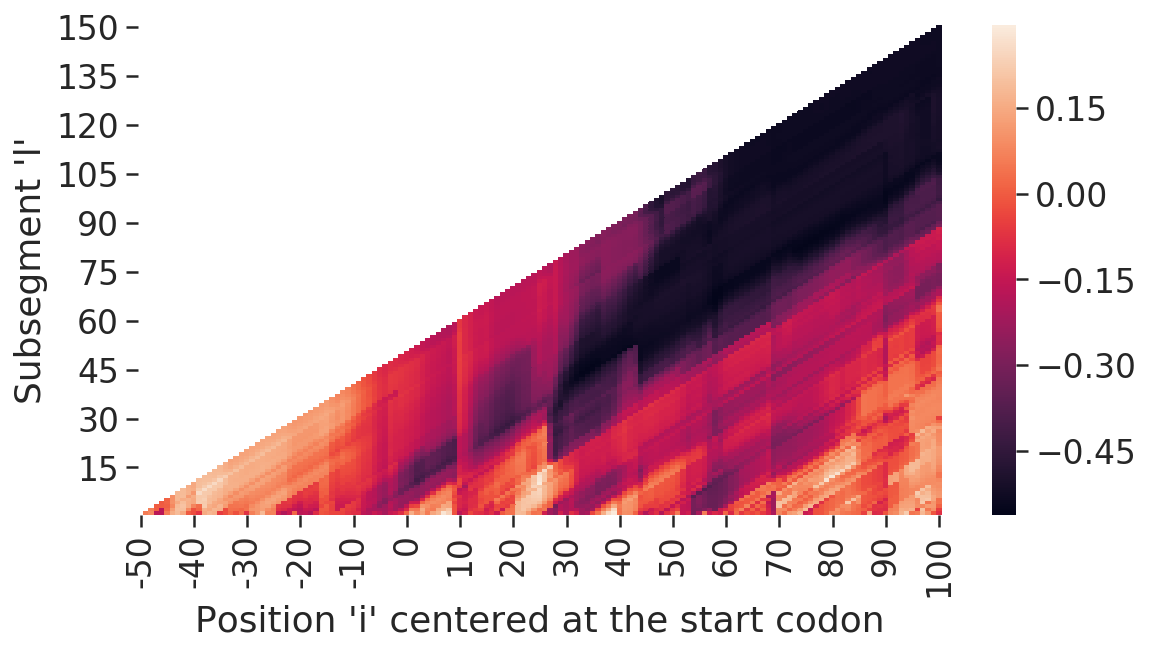

In [29]:
# Supplementary Fig 1B, right panel
dvir = d[["Position 'i' centered at the start codon", "Subsegment 'l'", 'dvir']]
dvir = dvir.pivot(index="Position 'i' centered at the start codon", columns="Subsegment 'l'", values='dvir').T.sort_values("Subsegment 'l'", ascending=False)
plot_heatmap(10, 15, dvir)

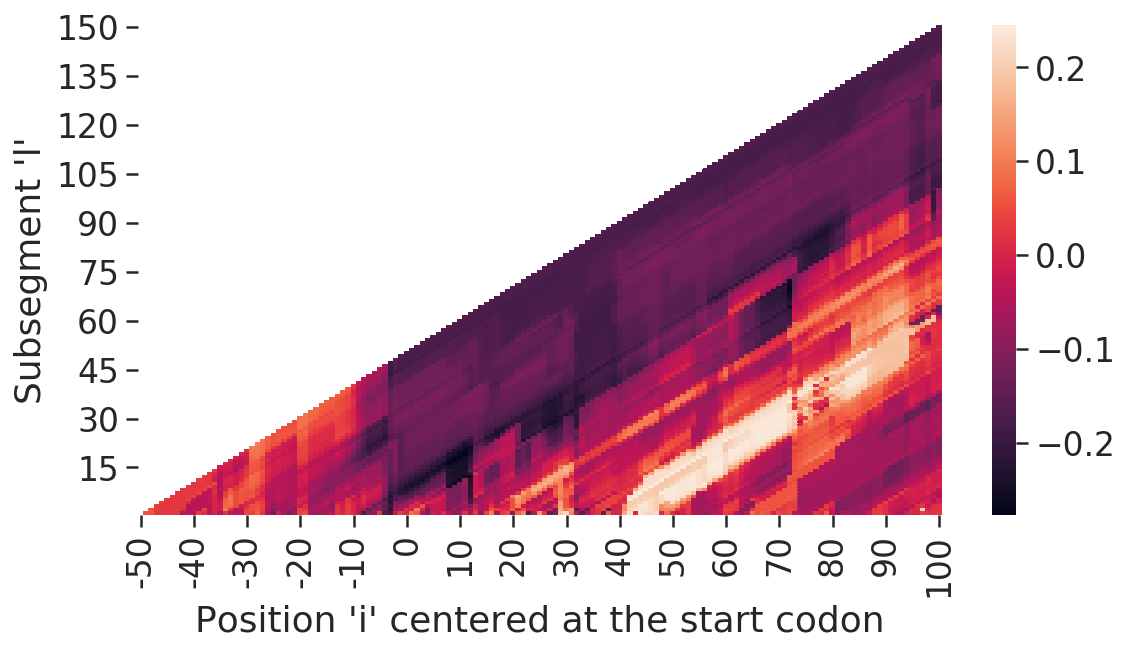

In [30]:
# Supplementary Fig 1C, right panel
noderer = d[["Position 'i' centered at the start codon", "Subsegment 'l'", 'noderer']]
noderer = noderer.pivot(index="Position 'i' centered at the start codon", columns="Subsegment 'l'", values='noderer').T.sort_values("Subsegment 'l'", ascending=False)
plot_heatmap(10, 15, noderer)

In [47]:
p = pd.read_csv('data/protein.noderer.out', sep='\t')
p = p.set_index('id')
f = pd.read_csv('data/rnafold.noderer.out', sep='\t')
f = f.set_index('id')

In [48]:
# o = get_openen(50, 300, 'data/TTCATCATGCA_openen', 19, 11, 'data/openen.noderer.pkl')
o = pd.read_pickle('data/sel.noderer.pkl') # precalculated
d = pd.concat([o, f, p], sort=True, axis=1)
d.corr(method='spearman')

,Opening energy,Folding energy (kcal/mol),Protein abundance
Opening energy,1.000000,-0.391379,-0.276545
Folding energy (kcal/mol),-0.391379,1.000000,0.123866
Protein abundance,-0.276545,0.123866,1.000000


In [36]:
spearmanr(d['Opening energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=-0.27654501570205875, pvalue=0.0)

In [33]:
spearmanr(d['Folding energy (kcal/mol)'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=0.26391670324521765, pvalue=7.193096030508314e-34)

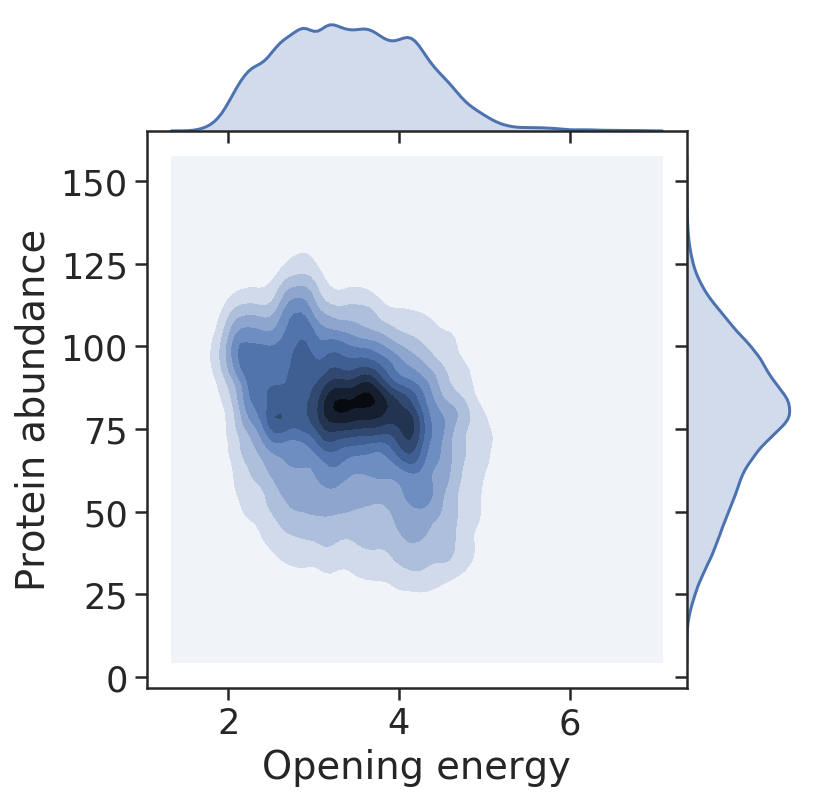

In [49]:
# Fig 1C
plot_joinplot('Opening energy', 'Protein abundance', d, 'b')

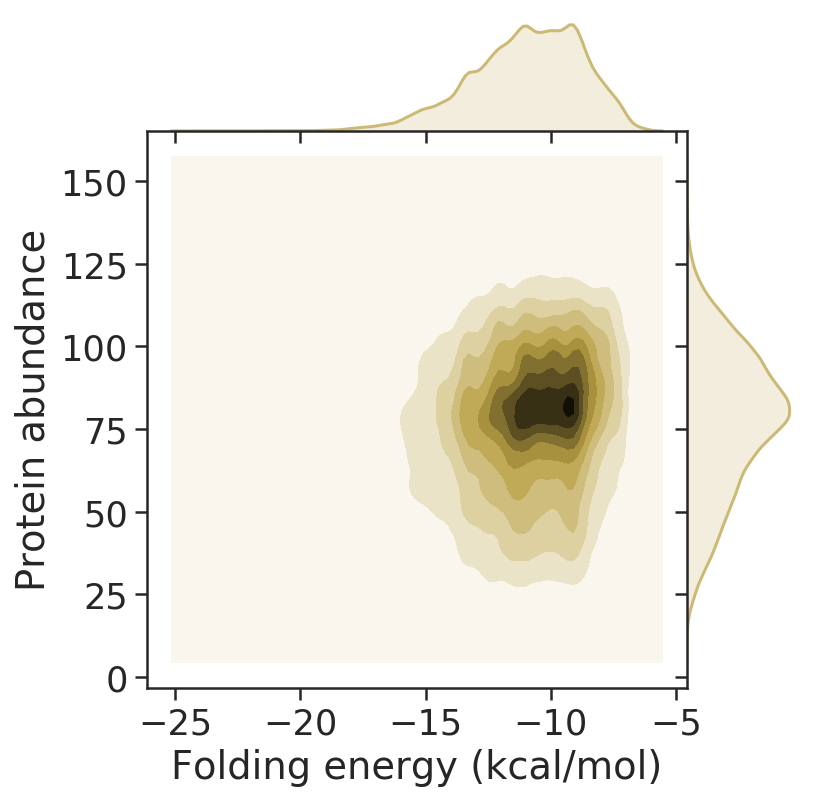

In [50]:
plot_joinplot('Folding energy (kcal/mol)', 'Protein abundance', d, 'y')

Next, we asked if correlation of GFP protein abundance and opening energy is predictive of the outcomes of recombinant protein production experiments. We analyze the results of pET21_NESG prokaryotic expression vector from TargetTrack/DNASU database (n=11,430).

```console
# Plasmid sequence
wget http://cpdwebdev.biodesign.asu.edu:8080/DNASURepository/file/sequence/pET21_NESG_sequence.doc

# Transcription start site of T7 promoter
# https://www.neb.com/faqs/2015/01/30/what-is-the-promoter-sequence-of-t7-rna-polymerase

python ../openen.py -s pET21_NESG.fa -x -S -n 71 -t 300 -p 16 -o openen.pET21_NESG
```

In [39]:
# Calculate AUC at individual subsegment 'l' (length 1 to 'u')
d = pd.read_pickle('data/openen.pET21_NESG.pkl')
d = d.set_index('id')
c = pd.read_csv('data/class.txt', sep='\t')
c.columns = ['id', 14706]
c = c.set_index('id').replace(2, 1)
df = pd.concat([d, c], axis=1, sort=True)
df = df.dropna()
df[14706] = df[14706].astype('int')

auc = pd.DataFrame(roc(14706, df))
auc = auc.set_index(0)
auc.columns = ['AUC']

In [40]:
# Get labels (row and column names) from an _openen file
# Join labels and AUC values
label = openen_label(71, 100, 'data/AaCD00331182_openen')
auc = pd.concat([label, auc], axis=1)
# Drop subsegment l=171 to make y-axis look nice
auc.drop(auc.tail(1).index, inplace=True)

# Transform correlation values to a dataframe similar to that of _openen
df = auc.pivot(index="Position 'i' centered at the start codon", columns="Subsegment 'l'", values='AUC').T.sort_values("Subsegment 'l'", ascending=False)

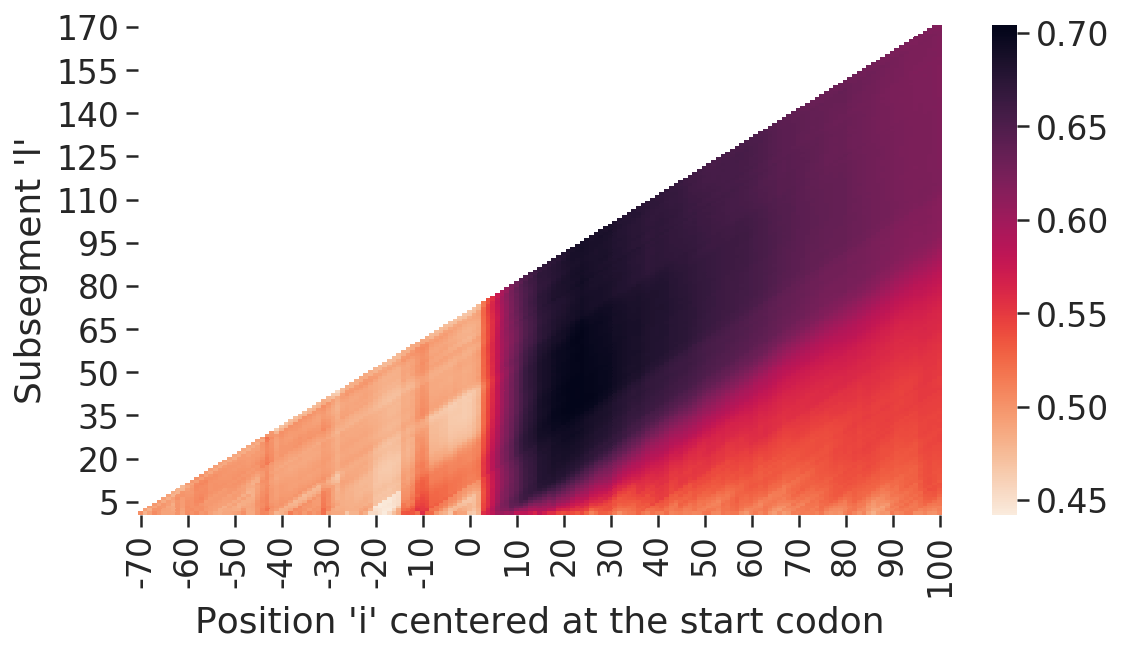

In [41]:
# Fig 2B
plot_heatmap(10, 15, df, colorflip=True)

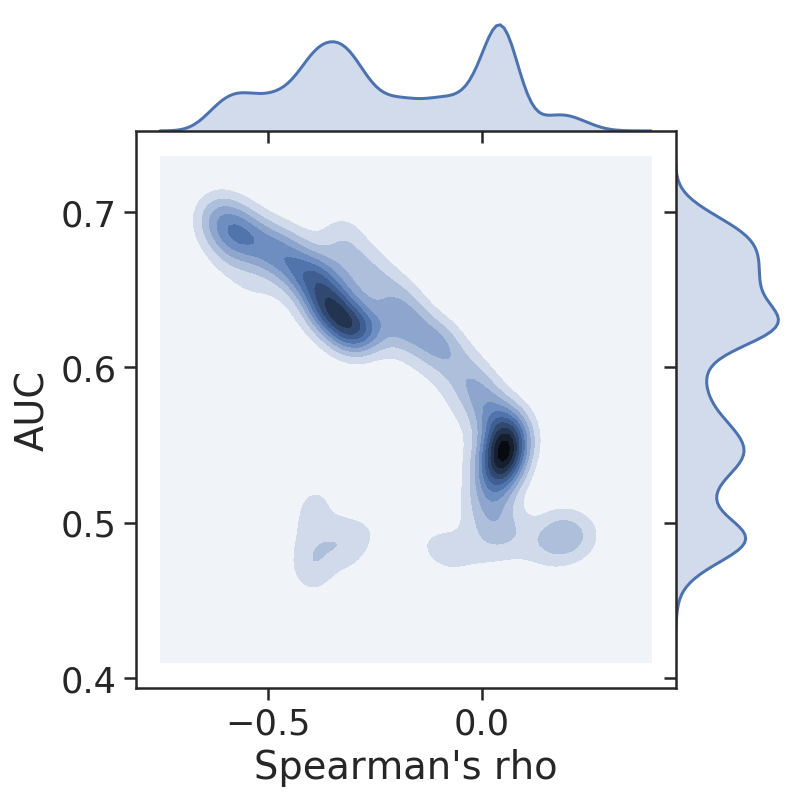

In [42]:
# Fig 2C
corr = pd.read_pickle('data/corr.cambray.pkl')
d = pd.merge(corr, auc, on=["Position 'i' centered at the start codon","Subsegment 'l'"])
d.rename(columns={'corr':"Spearman's rho"}, inplace=True)
plot_joinplot("Spearman's rho", 'AUC', d, 'b')

In [43]:
d.corr(method='spearman')["Spearman's rho"]['AUC']

-0.7035306024528327